## Periodogram for all DIA Objects

Author: Sandro

Last updated: 2025-01-15 by Sandro

In this notebook we will compute the periodogram for all DIA Objects.

In [1]:
import hats
import lsdb
import numpy as np
import pandas as pd
import pyarrow as pa
import astropy.units as u
import matplotlib.pyplot as plt

## Helper functions

These functions help us to manipulate fluxes to get magnitudes and their errors.

In [2]:
def create_mag_errors(df, flux_col_prefixes):
    """Move flux into magnitudes and calculate the error on the magnitude
    
    Parameters
    ----------
    sciFlux : `float`
        Science flux
    sciFluxErr : `float`
        Science flux error

    Returns
    -------
    mag, magerr  : `float`, `float`
        Magnitude and magnitude error
    """
    mag_cols = {}

    for prefix in flux_col_prefixes:
        flux, fluxErr = df[prefix+"Flux"], df[prefix+"FluxErr"]
 
        mag = u.nJy.to(u.ABmag, flux)
        upper_mag = u.nJy.to(u.ABmag, flux+fluxErr)
        lower_mag = u.nJy.to(u.ABmag, flux-fluxErr)
        magErr = -(upper_mag-lower_mag)/2

        mag_cols[f"{prefix}Mag"] = mag
        mag_cols[f"{prefix}MagErr"] = magErr

    # Convert the dictionary to a DataFrame and concatenate with the original dataframe
    mag_df = pd.DataFrame(mag_cols, dtype=pd.ArrowDtype(pa.float32()), index=df.index)

    # Return the original dataframe with new magnitude columns
    return pd.concat([df, mag_df], axis=1)

def degrees_to_radians(degrees):
    """
    Convert an angle from degrees to radians.

    Parameters:
    degrees (float): Angle in degrees.

    Returns:
    float: Angle in radians (unitless).
    """
    # Convert the input degrees to radians
    radians = (degrees * u.deg).to(u.rad)
    
    # Return the numerical value (without the unit)
    return radians.value

def radians_to_degrees(radians):
    """
    Convert an angle from radians to degrees.

    Parameters:
    radians (float): Angle in radians.

    Returns:
    float: Angle in degrees (unitless).
    """
    # Convert the input radians to degrees
    degrees = (radians * u.rad).to(u.deg)
    
    # Return the numerical value (without the unit)
    return degrees.value

def flux_to_magnitude(df_single_flux_src):
    """Magic function that converts flux to magnitude

    Args:
        df_single_flux_src (_type_): _description_

    Returns:
        _type_: _description_
    """
    
    # Define the zeropoints for each band
    zeropoints = {
        'u': 12.652350670009373,
        'g': 14.689449213373276,
        'r': 14.559501946792281,
        'i': 14.378976834902065,
        'z': 13.993052964496345,
        'y': 13.017367314857484
    }
    
    # Create an empty dictionary to hold magnitudes
    mag_dict = {}
    
    # Apply the transformation for each band
    for band in zeropoints.keys():
        # Make sure the flux column for the band exists in the dataframe
        flux_col = f'lsst_flux_{band}'
        if flux_col in df_single_flux_src.columns:
            mag_col = f'mag_{band}'
            # Calculate magnitudes from flux: mag = zp - 2.5 * log10(flux)
            # Handling zero or negative flux values to avoid invalid log10 operations
            mag_dict[mag_col] = zeropoints[band] - 2.5 * np.log10(df_single_flux_src[flux_col].replace(0, np.nan))
    
    # Convert the dictionary to a DataFrame and concatenate with the original dataframe
    mag_df = pd.DataFrame(mag_dict)
    
    # Return the original dataframe with new magnitude columns
    return pd.concat([df_single_flux_src, mag_df], axis=1)

## Loading the data

In [3]:
lsdb_dir = "/sdf/data/rubin/shared/lsdb_commissioning"
hats_dir = f"{lsdb_dir}/or4_dia/hats"

First, let's check what columns are useful for our use case:

In [ ]:
hats.read_hats(f"{hats_dir}/DiaObject-dedup").schema

_healpix_29: int64
diaObjectId: int64
validityStart: timestamp[ns, tz=UTC]
validityEnd: timestamp[ns, tz=UTC]
ra: double
raErr: double
dec: double
decErr: double
ra_dec_Cov: double
radecMjdTai: double
pmRa: null
pmRaErr: null
pmDec: null
pmDecErr: null
parallax: null
parallaxErr: null
pmRa_pmDec_Cov: null
pmRa_parallax_Cov: null
pmDec_parallax_Cov: null
pmParallaxLnL: null
pmParallaxChi2: null
pmParallaxNdata: int64
u_psfFluxMean: null
u_psfFluxMeanErr: null
u_psfFluxSigma: null
u_psfFluxChi2: null
u_psfFluxNdata: int64
u_fpFluxMean: null
u_fpFluxMeanErr: null
u_fpFluxSigma: null
g_psfFluxMean: double
g_psfFluxMeanErr: double
g_psfFluxSigma: double
g_psfFluxChi2: double
g_psfFluxNdata: int64
g_fpFluxMean: null
g_fpFluxMeanErr: null
g_fpFluxSigma: null
r_psfFluxMean: double
r_psfFluxMeanErr: double
r_psfFluxSigma: double
r_psfFluxChi2: double
r_psfFluxNdata: int64
r_fpFluxMean: null
r_fpFluxMeanErr: null
r_fpFluxSigma: null
i_psfFluxMean: double
i_psfFluxMeanErr: double
i_psfFluxSigma: 

Let's load the `DiaObjects` catalog and nest the respective sources:

In [5]:
diaObj = lsdb.read_hats(f"{hats_dir}/DiaObject-dedup", columns=["diaObjectId", "ra", "dec"])
diaObj

,diaObjectId,ra,dec
npartitions=103,,,
"Order: 6, Pixel: 31150",int64[pyarrow],double[pyarrow],double[pyarrow]
"Order: 7, Pixel: 124604",...,...,...
...,...,...,...
"Order: 7, Pixel: 195011",...,...,...
"Order: 6, Pixel: 48753",...,...,...


In [6]:
diaSource = lsdb.read_hats(
    f"{hats_dir}/DiaSource", 
    columns=[
        "diaObjectId",
        "ra",
        "dec",
        "midpointMjdTai",
        "band",
        "psfFlux",
        "psfFluxErr",
        "scienceFlux",
        "scienceFluxErr"
    ])
diaSource

,diaObjectId,ra,dec,midpointMjdTai,band,psfFlux,psfFluxErr,scienceFlux,scienceFluxErr
npartitions=101,,,,,,,,,
"Order: 6, Pixel: 31150",int64[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],string[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow]
"Order: 7, Pixel: 124604",...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...
"Order: 6, Pixel: 48752",...,...,...,...,...,...,...,...,...
"Order: 6, Pixel: 48753",...,...,...,...,...,...,...,...,...


In [7]:
# Calculate magnitudes for sources
new_meta = diaSource._ddf._meta.copy()
mag_cols = ["scienceMag", "scienceMagErr", "psfMag", "psfMagErr"]
for col in mag_cols:
    new_meta[col] = pd.Series(dtype=pd.ArrowDtype(pa.float32()))
diaSource = diaSource.map_partitions(create_mag_errors, flux_col_prefixes=["science","psf"], meta=new_meta)
diaSource

,diaObjectId,ra,dec,midpointMjdTai,band,psfFlux,psfFluxErr,scienceFlux,scienceFluxErr,scienceMag,scienceMagErr,psfMag,psfMagErr
npartitions=101,,,,,,,,,,,,,
"Order: 6, Pixel: 31150",int64[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],string[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow]
"Order: 7, Pixel: 124604",...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Order: 6, Pixel: 48752",...,...,...,...,...,...,...,...,...,...,...,...,...
"Order: 6, Pixel: 48753",...,...,...,...,...,...,...,...,...,...,...,...,...


In [8]:
#Added this now
diaSource = diaSource[~diaSource["scienceMagErr"].isna()]
diaSource = diaSource[~diaSource["psfMagErr"].isna()]

In [9]:
diaSource.head()

/sdf/group/rubin/sw/conda/envs/lsst-scipipe-9.0.0/lib/python3.11/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))


,diaObjectId,ra,dec,midpointMjdTai,band,psfFlux,psfFluxErr,scienceFlux,scienceFluxErr,scienceMag,scienceMagErr,psfMag,psfMagErr
_healpix_29,,,,,,,,,,,,,
2192019157258638915,3068429594525696001,250.0514,1.374347,60488.259713,i,1835.659302,349.681396,1194.622437,285.8013,23.706923,0.264885,23.24052,0.209384
2192019157258638915,3068429594525696001,250.0514,1.374347,60488.259713,i,1835.659302,349.681396,1194.622437,285.8013,23.706923,0.264885,23.24052,0.209384
2192019157258638915,3068429594525696001,250.0514,1.374347,60488.259713,i,1835.659302,349.681396,1194.622437,285.8013,23.706923,0.264885,23.24052,0.209384
2192019157927770263,3068429594525696035,250.051797,1.376045,60488.259713,i,1884.956665,348.054169,725.212585,284.412292,24.248837,0.449898,23.211746,0.202806
2192019157927770263,3068429594525696035,250.051797,1.376045,60488.259713,i,1884.956665,348.054169,725.212585,284.412292,24.248837,0.449898,23.211746,0.202806


In [10]:
diaObj = diaObj.join_nested(diaSource, left_on="diaObjectId", right_on="diaObjectId", nested_column_name="source")
# Filter to a single band (e.g. "r")
diaObj = diaObj.query("source.band == 'r'")
# Make sure we have at least 2 observations
diaObj = diaObj.reduce(lambda mjd: {"nobs": mjd.size}, "source.midpointMjdTai", meta={"nobs": int}, append_columns=True)
diaObj = diaObj.query("nobs > 10")
diaObj

/sdf/home/s/stavar/.local/lib/python3.11/site-packages/lsdb/dask/join_catalog_data.py:332: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(


,diaObjectId,ra,dec,source,nobs
npartitions=110,,,,,
"Order: 6, Pixel: 31150",int64[pyarrow],double[pyarrow],double[pyarrow],"nested<ra: [double], dec: [double], midpointMj...",int64
"Order: 7, Pixel: 124604",...,...,...,...,...
...,...,...,...,...,...
"Order: 7, Pixel: 195011",...,...,...,...,...
"Order: 6, Pixel: 48753",...,...,...,...,...


In [11]:
diaObj.head()["source"].iloc[0]

/sdf/group/rubin/sw/conda/envs/lsst-scipipe-9.0.0/lib/python3.11/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-9.0.0/lib/python3.11/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-9.0.0/lib/python3.11/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-9.0.0/lib/python3.11/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-9.0.0/lib/python3.11/site-packages/astropy/units/function/logarithmi

,ra,dec,midpointMjdTai,band,psfFlux,psfFluxErr,scienceFlux,scienceFluxErr,scienceMag,scienceMagErr,psfMag,psfMagErr
0,249.754901,1.607554,60488.241090,r,41205.695312,339.352051,51078.753906,312.885468,19.629398,0.006651,19.862606,0.008942
1,249.754901,1.607554,60488.241090,r,41205.695312,339.352051,51078.753906,312.885468,19.629398,0.006651,19.862606,0.008942
2,249.754906,1.607554,60488.242498,r,39873.226562,347.688171,49403.941406,306.866760,19.665596,0.006744,19.898296,0.009468
3,249.754906,1.607554,60488.242498,r,39873.226562,347.688171,49403.941406,306.866760,19.665596,0.006744,19.898296,0.009468
4,249.754897,1.607554,60488.243430,r,39719.726562,341.094238,49685.261719,316.791046,19.659431,0.006923,19.902485,0.009324
5,249.754897,1.607554,60488.243430,r,39719.726562,341.094238,49685.261719,316.791046,19.659431,0.006923,19.902485,0.009324
6,249.754900,1.607557,60488.245772,r,36379.722656,332.117218,45939.097656,310.610901,19.744543,0.007341,19.997852,0.009912
7,249.754900,1.607557,60488.245772,r,36379.722656,332.117218,45939.097656,310.610901,19.744543,0.007341,19.997852,0.009912
8,249.754851,1.607586,60489.228748,r,1226.686646,216.188950,9148.512695,174.488937,21.496624,0.020711,23.678165,0.193367
9,249.754872,1.607610,60489.229214,r,1830.002563,216.184464,9695.977539,180.039307,21.433521,0.020163,23.243872,0.128863


As well as the OR4 data ground truth, which we will use to compare with our results.

In [12]:
or4_truth = lsdb.read_hats(f"{lsdb_dir}/or4_truth")
or4_truth

,id,ra,dec,host_galaxy_id,magnorm,sed_filepath,MW_rv,MW_av,mura,mudec,radial_velocity,parallax,period,mag_amplitude,phase,lsst_flux_u,lsst_flux_g,lsst_flux_r,lsst_flux_i,lsst_flux_z,lsst_flux_y,Norder,Dir,Npix
npartitions=4,,,,,,,,,,,,,,,,,,,,,,,,
"Order: 0, Pixel: 7",int64[pyarrow],double[pyarrow],double[pyarrow],int64[pyarrow],double[pyarrow],string[pyarrow],float[pyarrow],float[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],uint8[pyarrow],uint64[pyarrow],uint64[pyarrow]
"Order: 0, Pixel: 8",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Order: 0, Pixel: 10",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Order: 0, Pixel: 11",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [13]:
# Calculate magnitudes for true data in objects
new_meta = or4_truth._ddf._meta.copy()
for col in [f"mag_{band}" for band in list("ugrizy")]:
    new_meta[col] = pd.Series(dtype=np.float32)
or4_truth = or4_truth.map_partitions(flux_to_magnitude, meta=new_meta)
or4_truth.head()

,id,ra,dec,host_galaxy_id,magnorm,sed_filepath,MW_rv,MW_av,mura,mudec,...,lsst_flux_y,Norder,Dir,Npix,mag_u,mag_g,mag_r,mag_i,mag_z,mag_y
_healpix_29,,,,,,,,,,,,,,,,,,,,,
2217160494889095813,1062765811,249.912146,4.422765,0,20.633459,starSED/kurucz/km25_5500.fits_g15_5700.gz,3.1,0.209597,-1.42,-0.62,...,0.001245,0,0,7,21.918722,20.978501,20.553560,20.378163,20.311240,20.279071
2217160415517095732,384429745,249.896439,4.40529,0,24.00631,starSED/phoSimMLT/lte032-4.5-1.0a+0.4.BT-Settl...,3.1,0.207343,-3.32,-4.88,...,0.001384,0,0,7,26.277483,23.755537,22.532154,21.062542,20.462552,20.164630
2217160414541984566,1150780452,249.90238,4.40611,0,27.007699,starSED/phoSimMLT/lte037-5.5-1.0a+0.4.BT-Settl...,3.1,0.207343,-2.17,-1.84,...,0.000027,0,0,7,29.532081,27.124650,25.801770,25.011228,24.654629,24.457803
2217160465203166803,1062764341,249.911316,4.413649,0,28.555489,starSED/phoSimMLT/lte034-4.5-1.0a+0.4.BT-Settl...,3.1,0.20847,-1.81,-3.11,...,0.000011,0,0,7,30.910082,28.513519,27.254175,26.133309,25.649080,25.399580
2217159695104336626,786170978,249.867225,4.398707,0,24.001995,starSED/kurucz/km45_4000.fits_g10_4060.gz,3.1,0.207343,-5.43,-3.66,...,0.000232,0,0,7,26.759422,24.470829,23.173144,22.565826,22.276699,22.103449


## Crossmatch with true data

Let's crossmatch with the truth OR4 data to compare our calculated periods vs the true ones.

In [14]:
diaObj_x_truth = diaObj.crossmatch(or4_truth, radius_arcsec=1, suffixes=("_dia",""))
diaObj_x_truth

/sdf/home/s/stavar/.local/lib/python3.11/site-packages/lsdb/dask/crossmatch_catalog_data.py:108: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(


,diaObjectId_dia,ra_dia,dec_dia,source_dia,nobs_dia,id,ra,dec,host_galaxy_id,magnorm,sed_filepath,MW_rv,MW_av,mura,mudec,radial_velocity,parallax,period,mag_amplitude,phase,lsst_flux_u,lsst_flux_g,lsst_flux_r,lsst_flux_i,lsst_flux_z,lsst_flux_y,Norder,Dir,Npix,mag_u,mag_g,mag_r,mag_i,mag_z,mag_y,_dist_arcsec
npartitions=110,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Order: 6, Pixel: 31150",int64[pyarrow],double[pyarrow],double[pyarrow],"nested<ra: [double], dec: [double], midpointMj...",int64,int64[pyarrow],double[pyarrow],double[pyarrow],int64[pyarrow],double[pyarrow],string[pyarrow],float[pyarrow],float[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],uint8[pyarrow],uint64[pyarrow],uint64[pyarrow],float32,float32,float32,float32,float32,float32,double[pyarrow]
"Order: 7, Pixel: 124604",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Order: 7, Pixel: 195011",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Order: 6, Pixel: 48753",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [15]:
diaObj_x_truth["source_dia"].head().iloc[0]

/sdf/group/rubin/sw/conda/envs/lsst-scipipe-9.0.0/lib/python3.11/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-9.0.0/lib/python3.11/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-9.0.0/lib/python3.11/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-9.0.0/lib/python3.11/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-9.0.0/lib/python3.11/site-packages/astropy/units/function/logarithmi

/sdf/group/rubin/sw/conda/envs/lsst-scipipe-9.0.0/lib/python3.11/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-9.0.0/lib/python3.11/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-9.0.0/lib/python3.11/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-9.0.0/lib/python3.11/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-9.0.0/lib/python3.11/site-packages/astropy/units/function/logarithmi

,ra,dec,midpointMjdTai,band,psfFlux,psfFluxErr,scienceFlux,scienceFluxErr,scienceMag,scienceMagErr,psfMag,psfMagErr
0,249.754901,1.607554,60488.241090,r,41205.695312,339.352051,51078.753906,312.885468,19.629398,0.006651,19.862606,0.008942
1,249.754901,1.607554,60488.241090,r,41205.695312,339.352051,51078.753906,312.885468,19.629398,0.006651,19.862606,0.008942
2,249.754906,1.607554,60488.242498,r,39873.226562,347.688171,49403.941406,306.866760,19.665596,0.006744,19.898296,0.009468
3,249.754906,1.607554,60488.242498,r,39873.226562,347.688171,49403.941406,306.866760,19.665596,0.006744,19.898296,0.009468
4,249.754897,1.607554,60488.243430,r,39719.726562,341.094238,49685.261719,316.791046,19.659431,0.006923,19.902485,0.009324
5,249.754897,1.607554,60488.243430,r,39719.726562,341.094238,49685.261719,316.791046,19.659431,0.006923,19.902485,0.009324
6,249.754900,1.607557,60488.245772,r,36379.722656,332.117218,45939.097656,310.610901,19.744543,0.007341,19.997852,0.009912
7,249.754900,1.607557,60488.245772,r,36379.722656,332.117218,45939.097656,310.610901,19.744543,0.007341,19.997852,0.009912
8,249.754851,1.607586,60489.228748,r,1226.686646,216.188950,9148.512695,174.488937,21.496624,0.020711,23.678165,0.193367
9,249.754872,1.607610,60489.229214,r,1830.002563,216.184464,9695.977539,180.039307,21.433521,0.020163,23.243872,0.128863


## Extract features from light curves

We will now write custom analysis functions to compute features (statistics) on each light curve. Some of these timeseries features (e.g. Von Neumann, excess variance) characterize the amount of outliers in the timeseries. They have been heavily used in literature, for example, to find variable stars.

In [16]:
%pip install -q light-curve --only-binary light-curve
import light_curve as licu

Note: you may need to restart the kernel to use updated packages.


In [17]:
extractor = licu.Extractor(
    licu.Periodogram(
        peaks=1,
        max_freq_factor=10.0,
        resolution=50.0,
    ),
    licu.WeightedMean(),  # Mean magnitude
    licu.Eta(),  # Von Neumann's eta statistics
    licu.ExcessVariance(),  # Excess variance statistics
    licu.Amplitude(),  # 0.5 * [max(mag) - min(mag)]
)

# light-curve package requires all arrays to be the same dtype.
# It also requires the time array to be ordered and to have no duplicates.
def calc_features(mjd, mag, magerr, **kwargs):
    # We offset date, so we still would have <1 second precision
    t = np.asarray(mjd - 60000, dtype=np.float32)
    _, sort_index = np.unique(t, return_index=True)
    features = extractor(
        t[sort_index],
        mag[sort_index],
        magerr[sort_index],
        **kwargs,
    )
    # Return the features as a dictionary
    return dict(zip(extractor.names, features))


features = diaObj_x_truth.reduce(
    calc_features,
    "source_dia.midpointMjdTai",
    "source_dia.scienceMag",
    "source_dia.scienceMagErr",
    meta={name: np.float32 for name in extractor.names},
    append_columns=True,
)
features

,diaObjectId_dia,ra_dia,dec_dia,source_dia,nobs_dia,id,ra,dec,host_galaxy_id,magnorm,sed_filepath,MW_rv,MW_av,mura,mudec,radial_velocity,parallax,period,mag_amplitude,phase,lsst_flux_u,lsst_flux_g,lsst_flux_r,lsst_flux_i,lsst_flux_z,lsst_flux_y,Norder,Dir,Npix,mag_u,mag_g,mag_r,mag_i,mag_z,mag_y,_dist_arcsec,period_0,period_s_to_n_0,weighted_mean,eta,excess_variance,amplitude
npartitions=110,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Order: 6, Pixel: 31150",int64[pyarrow],double[pyarrow],double[pyarrow],"nested<ra: [double], dec: [double], midpointMj...",int64,int64[pyarrow],double[pyarrow],double[pyarrow],int64[pyarrow],double[pyarrow],string[pyarrow],float[pyarrow],float[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],uint8[pyarrow],uint64[pyarrow],uint64[pyarrow],float32,float32,float32,float32,float32,float32,double[pyarrow],float32,float32,float32,float32,float32,float32
"Order: 7, Pixel: 124604",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Order: 7, Pixel: 195011",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Order: 6, Pixel: 48753",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [18]:
computed_features = features.compute()

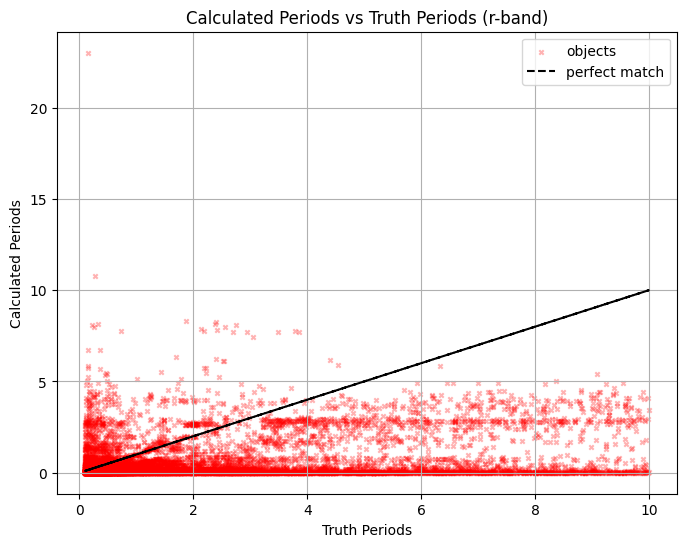

In [47]:
# Plot periods vs truth periods on r-band
truth_periods = computed_features["period"]
calculated_periods = computed_features["period_0"]

plt.figure(figsize=(8, 6))
plt.scatter(truth_periods, calculated_periods, label="objects", marker="x", s=10, color="red", alpha=0.3)
plt.plot(truth_periods, truth_periods, color='black', linestyle='--', label="perfect match")
plt.xlabel("Truth Periods")
plt.ylabel("Calculated Periods")
plt.legend()
plt.title("Calculated Periods vs Truth Periods (r-band)")
plt.grid()
plt.show()

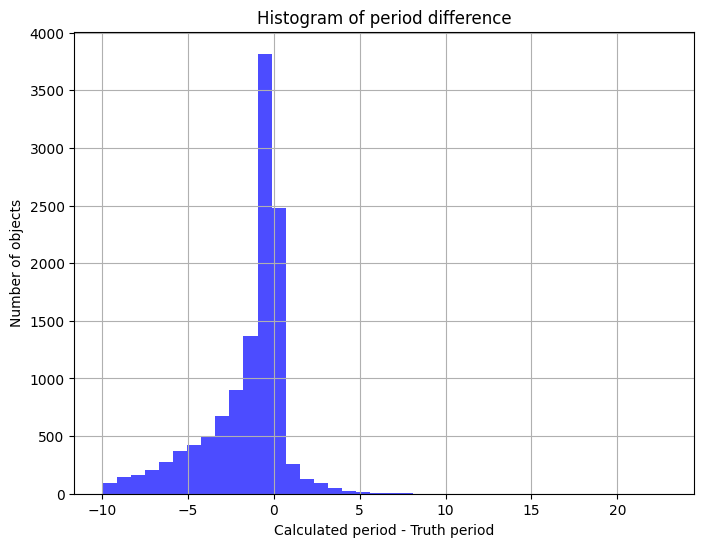

In [45]:
differences = calculated_periods - truth_periods

plt.figure(figsize=(8, 6))
plt.hist(differences, bins=40, color='blue', alpha=0.7)
plt.xlabel("Calculated period - Truth period")
plt.ylabel("Number of objects")
plt.title("Histogram of period difference")
plt.grid()
plt.show()

In [48]:
featuresPsf = diaObj_x_truth.reduce(
    calc_features,
    "source_dia.midpointMjdTai",
    "source_dia.psfMag",
    "source_dia.psfMagErr",
    meta={name: np.float32 for name in extractor.names},
    append_columns=True,
)
featuresPsf

,diaObjectId_dia,ra_dia,dec_dia,source_dia,nobs_dia,id,ra,dec,host_galaxy_id,magnorm,sed_filepath,MW_rv,MW_av,mura,mudec,radial_velocity,parallax,period,mag_amplitude,phase,lsst_flux_u,lsst_flux_g,lsst_flux_r,lsst_flux_i,lsst_flux_z,lsst_flux_y,Norder,Dir,Npix,mag_u,mag_g,mag_r,mag_i,mag_z,mag_y,_dist_arcsec,period_0,period_s_to_n_0,weighted_mean,eta,excess_variance,amplitude
npartitions=110,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Order: 6, Pixel: 31150",int64[pyarrow],double[pyarrow],double[pyarrow],"nested<ra: [double], dec: [double], midpointMj...",int64,int64[pyarrow],double[pyarrow],double[pyarrow],int64[pyarrow],double[pyarrow],string[pyarrow],float[pyarrow],float[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],uint8[pyarrow],uint64[pyarrow],uint64[pyarrow],float32,float32,float32,float32,float32,float32,double[pyarrow],float32,float32,float32,float32,float32,float32
"Order: 7, Pixel: 124604",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Order: 7, Pixel: 195011",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Order: 6, Pixel: 48753",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [49]:
computed_featuresPsf = featuresPsf.compute()

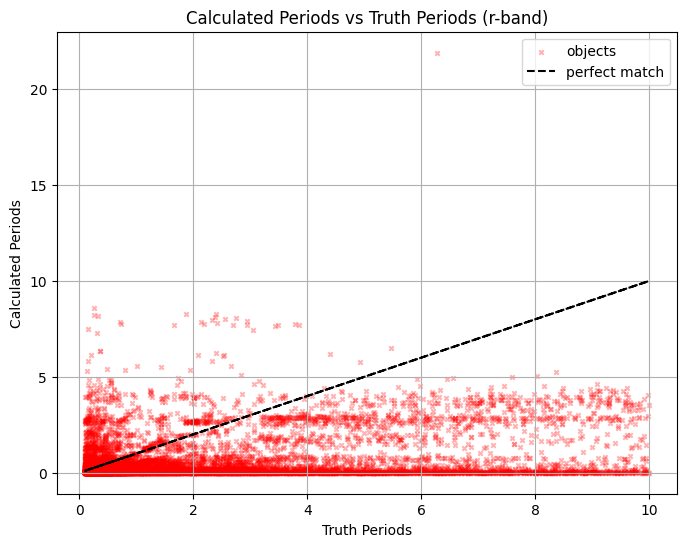

In [50]:
# Plot periods vs truth periods on r-band
truth_periods = computed_featuresPsf["period"]
calculated_periods = computed_featuresPsf["period_0"]

plt.figure(figsize=(8, 6))
plt.scatter(truth_periods, calculated_periods, label="objects", marker="x", s=10, color="red", alpha=0.3)
plt.plot(truth_periods, truth_periods, color='black', linestyle='--', label="perfect match")
plt.xlabel("Truth Periods")
plt.ylabel("Calculated Periods")
plt.legend()
plt.title("Calculated Periods vs Truth Periods (r-band)")
plt.grid()
plt.show()